<a href="https://colab.research.google.com/github/supanat-tht/HDAT9910/blob/main/HDAT9910_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HDAT 9910 Capstone Project

**Authors**: Supanat Thitipatarakorn

**zID**: z5383184

**Creation date**: 22 February 2024

**Purpose of this notebook**: To demonstrate data mingling of MIMIC-III data and answer two research questions: 1) mortality prediction in ICU and 2) weekend effect in ICU.

---
## Introduction

Here are some suggested grammar corrections for the given text:

Patients admitted to hospitals are sent to the appropriate wards depending on their conditions. Patients with critical conditions in need of close monitoring and medical care will be admitted or transferred to intensive care units (ICUs). Because of the nature of their conditions, patients in ICUs often have a higher mortality rate than patients in regular wards.

MIMIC-III is a large database containing deidentified health-related data associated with over forty thousand patients who stayed in the intensive care units of the Beth Israel Deaconess Medical Center in Boston, Massachusetts, between 2001 and 2012. The data was gathered from the Philips CareVue Clinical Information System and iMDsoft MetaVision ICU. MIMIC-III is available to researchers worldwide for data study including performing various data science tasks.

This notebook aims to utilize data science procedures on the MIMIC-III data to 1) build a predictive algorithm based on data from the first 24 hours in the ICU and 2) to investigate whether admission to the ICU on weekends increases the risk of ICU mortality.

## 1. Read and check the data. Prepare the data so they can be used by the algorithms.

### Setup

In [1]:
# Autosave every 60 minutes
%autosave 60

Autosaving every 60 seconds


In [2]:
# Check required libraries are installed if not calling system to install
import sys
import subprocess
import pkg_resources

required = {'numpy', 'pandas', 'plotnine', 'matplotlib', 'seaborn',
            'grid', 'shap', 'scikit-learn'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    print('Installing: ', missing)
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
# Delete unwanted variables
del required
del installed
del missing

# Load the rpy2 package to use R alongside Python
%load_ext rpy2.ipython

Installing:  {'shap', 'grid'}


In [3]:
# Mount Google Drive

if 'google.colab' in str(get_ipython()):
    from google.colab import drive # import drive from Gogle colab
    root = '/content/drive'     # default location for the drive
    # print(root)                 # print content of ROOT (Optional)
    drive.mount(root)
else:
    print('Not running on CoLab')

Mounted at /content/drive


In [4]:
# Assign the project path

from pathlib import Path

if 'google.colab' in str(get_ipython()):
    project_path = Path(root) / 'MyDrive' / 'HDAT9910'
else:
    project_path = Path()

In [5]:
# Function to plot the confusion matrix
def plot_confusion_matrix(confusion_matrix):
  # visualise the confusion matrix
  labels = ['No', 'Yes']
  ax = plt.subplot()
  sns.heatmap(confusion_matrix, annot = True, fmt = '.0f', ax = ax, cmap = 'viridis')

  # labels, titles and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

## Load the data

In [9]:
# Load the .csv file
import pandas as pd
alldata_q1 = pd.read_csv(Path(project_path) / 'alldata_q1.csv')

# Display shape
print("Shape:", alldata_q1.shape)

Shape: (32556, 59)


In [10]:
# Set the display rows to unlimited
import pandas as pd
pd.set_option("display.max_rows", None)

# Check features:
alldata_q1.apply(lambda c: c.value_counts(dropna=False).to_dict())

age_years                           {91.4: 1621, 78.0: 761, 77.0: 756, 76.0: 719, ...
icu_expire_flag_2                                                 {0: 29994, 1: 2562}
weekend                                                           {0: 26817, 1: 5739}
genderF                                                          {0: 18499, 1: 14057}
genderM                                                          {1: 18499, 0: 14057}
admission_type_2ELECTIVE                                          {0: 27239, 1: 5317}
admission_type_2EMERGENCY.URGENT                                  {1: 27239, 0: 5317}
ethnicity_2BLACK                                                  {0: 30104, 1: 2452}
ethnicity_2OTHER.UNKNOWN                                          {0: 25675, 1: 6881}
ethnicity_2WHITE                                                  {1: 23223, 0: 9333}
first_careunitCCU                                                 {0: 27804, 1: 4752}
first_careunitCSRU                                    

### Split the features and the target

In [18]:
# Split the data set into two DataFrames: the features, stored in X, and the target, stored in y.
X = alldata_q1.drop(['icu_expire_flag_2'], axis = 1)
y = alldata_q1[['icu_expire_flag_2']].values.ravel()

### Train-test split

In [15]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
# Split X and y into 80% train and 20% test data, set random state = 42 and stratify responses
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

---
## Logistic Regression model

### Training and hyperparameter tuning of the Logistic Regression model

In [16]:
# Import the standard scaler function
from sklearn.preprocessing import StandardScaler
# Import the logistic regression model
from sklearn.linear_model import LogisticRegression
# Import the pipeline function
from sklearn.pipeline import Pipeline


# Scaler object
standard_scaler = StandardScaler()

# Classifcaiton model
log_reg = LogisticRegression(solver='liblinear', random_state=0)

# Pipeline
pipeln = Pipeline([('Transform', standard_scaler), ('Estimator', log_reg)])

# Defining the hyper-parameters grid:
# I weight Class 1 more than Class 0 because Class 1 is less frequent than Class 0 in the data set.
param_grid_LR = {'Estimator__C': [10, 100],
              'Estimator__class_weight': [{0:0.2, 1:0.8}, {0:0.3, 1:0.7}],
              'Estimator__penalty': ['l1', 'l2']}

In [17]:
# Import the grid search CV class
from sklearn.model_selection import GridSearchCV

# Grid search CV object
# Specify cv = 3 for 3-fold cross-validation. F1 score is chosen because this is an imbalanced data set.
grid_search_LR = GridSearchCV(pipeln, param_grid_LR, cv = 3, scoring='f1', n_jobs=-1)

# Fit the model
grid_search_LR.fit(X_train, y_train)

# Display the best hyperparameters and F1 score
print("Best hyper-parameters: {}".format(grid_search_LR.best_params_))
print("Best cross-validation (F1) score: {:.4f}".format(grid_search_LR.best_score_))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best hyper-parameters: {'Estimator__C': 100, 'Estimator__class_weight': {0: 0.2, 1: 0.8}, 'Estimator__penalty': 'l2'}
Best cross-validation (F1) score: 0.4861


### Evaluation of the Logistic Regression model on the training and test sets

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      6000
           1       0.40      0.61      0.49       512

    accuracy                           0.90      6512
   macro avg       0.68      0.77      0.72      6512
weighted avg       0.92      0.90      0.91      6512



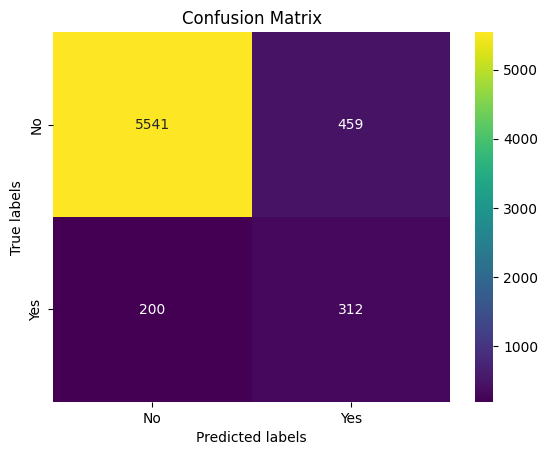

In [20]:
# Python code here (10 lines limit, and 2 cells limit)
# Import evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions for test data based on the model with best parameters generated by GridSearchCV
y_pred_grid_search_LR = grid_search_LR.predict(X_test)

# Generate confusion matrix for evaluation
confusion_LR = confusion_matrix(y_test, y_pred_grid_search_LR)

# Use the function plot_confusion_matrix(confusion_matrix)
plot_confusion_matrix(confusion_LR)

# Classification report
print("Classification report:")
print(classification_report(y_test, y_pred_grid_search_LR))

---
## Random Forest model

### Training and hyperparameter tuning of the Random Forest model

In [21]:
# Ignore warnings and import Random Forest Classifier
import warnings; warnings.simplefilter('ignore')
from sklearn.ensemble import RandomForestClassifier

# Define the model
random_forest = RandomForestClassifier(random_state=0)

# Defining the hyper-parameters grid:
# I weight Class 1 more than Class 0 because Class 1 is less frequent than Class 0 in the data set.
param_grid_RF = {'n_estimators': [150, 200],
                 'class_weight': [{0:0.2, 1:0.8}, {0:0.3, 1:0.7}],
                 'max_features': [20, 30],
                 'min_samples_split': [20, 25]}

In [ ]:
# Grid search CV object
# Specify cv = 3 for 3-fold cross-validation. F1 score is chosen because this is an imbalanced data set.
grid_search_RF = GridSearchCV(random_forest, param_grid_RF, cv = 3, scoring='f1', n_jobs=-1)

# Fit the model
grid_search_RF.fit(X_train, y_train)

# Display the best hyperparameters and F1 score
print("Best hyper-parameters: {}".format(grid_search_RF.best_params_))
print("Best cross-validation (F1) score: {:.4f}".format(grid_search_RF.best_score_))